In [ ]:
!pip install pvlib
!pip install --force-reinstall --no-deps git+https://github.com/isi-ies-group/cpvlib.git

In [1]:
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt
import numpy as np
from cpvlib import cpvsystem

# Datos del módulo de vidrio solar

In [2]:
mod_params_vidrio = {
    'alpha_sc': 0.0008*8.93,#temp coef of Isc 0.007144
    'I_L_ref': 8.994,
    'I_o_ref': 0.00000157,
    'R_s': 0.01,
    'R_sh_0': 8000,
    'cells_in_series': 10,
    'R_sh_ref': 3000,
    'gamma_ref': 1.528,
    'mu_gamma': 0.002,
    'EgRef': 1.121,
}

system = {   
    'surface_tilt': 30,
    'surface_azimuth': 180,
}

# Datos del módulo híbrido de Insolight

In [3]:
mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

# Obtención de datos solares

In [4]:
lat, lon, alt, tz = 40.4, -3.7, 695, 'utc'
location = pvlib.location.Location(latitude=lat, 
                                   longitude=lon, 
                                   altitude=alt, 
                                   tz=tz)

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)
data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data.index = pd.to_datetime(data.index)
data = data.sort_index()
data1 = data['2010']  #Seleccionar un año completo
data2 = data['2010-04']  #Seleccionar un mes completo
data3 = data['2010-07-01':'2010-07-05']  #Seleccionar periodo entre fechas

data0 = data1  #Usado para las gráficas:

solar_zenith = location.get_solarposition(data0.index).zenith
solar_azimuth = location.get_solarposition(data0.index).azimuth

In [5]:
dii = pvlib.irradiance.beam_component(system['surface_tilt'],
                                      system['surface_azimuth'],
                                      solar_zenith,
                                      solar_azimuth,
                                      dni=data0['dni'])

aoi = pvlib.irradiance.aoi(system['surface_tilt'], 
                           system['surface_azimuth'],
                           solar_zenith,
                           solar_azimuth)

poa_sky=pvlib.irradiance.get_sky_diffuse(system['surface_tilt'],
                                         system['surface_azimuth'],
                                         solar_zenith, 
                                         solar_azimuth, 
                                         ghi=data0['ghi'],
                                         dhi=data0['dhi'],
                                         dni=data0['dni'],
                                         dni_extra=None, 
                                         airmass=None, 
                                         model='isotropic', 
                                         model_perez='allsitescomposite1990')

poa_ground=pvlib.irradiance.get_ground_diffuse(system['surface_tilt'], 
                                               ghi=data0['ghi'], 
                                               albedo=0.25, 
                                               surface_type=None)

poa_irrad=pvlib.irradiance.poa_components(aoi=aoi, 
                                          dni=data0['dni'], 
                                          poa_sky_diffuse=poa_sky, 
                                          poa_ground_diffuse=poa_ground)

effectiveIrradiance = poa_irrad.poa_direct * np.absolute(np.cos(aoi)) * pvlib.iam.ashrae(aoi) + poa_irrad.poa_diffuse


# Cálculos para el vídrio solar

In [6]:
tempcell=pvlib.temperature.pvsyst_cell(poa_irrad.poa_global, 
                                       data0['temp_air'], 
                                       data0['wind_speed'])

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_pvsyst(
    effective_irradiance=effectiveIrradiance,
    temp_cell=tempcell,
    alpha_sc=mod_params_vidrio['alpha_sc'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
    gamma_ref=mod_params_vidrio['gamma_ref'],
    mu_gamma=mod_params_vidrio['mu_gamma'],
    R_sh_0=mod_params_vidrio['R_sh_0'],
    cells_in_series=18
)

dc = pvlib.pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw'
)

# Cálculos para el módulo híbrido de Insolight

In [7]:
static_hybrid_sys = cpvsystem.StaticHybridSystem(
    surface_tilt=system['surface_tilt'],
    surface_azimuth=system['surface_azimuth'],
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

dii_effective, poa_flatplate_static_effective = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    #iam_param=0.7,
    #aoi_limit=55,
    dii=None,
    ghi=data0['ghi'],
    dhi=data0['dhi'],
    dni=data0['dni']
)


temp_cell_35, temp_cell_flatplate = static_hybrid_sys.pvsyst_celltemp(
    dii=dii_effective,
    poa_flatplate_static=poa_flatplate_static_effective,
    temp_air=data0['temp_air'],
    wind_speed=data0['wind_speed']
)

diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=dii_effective,
    poa_flatplate_static=poa_flatplate_static_effective,
    temp_cell_cpv=temp_cell_35,
    temp_cell_flatplate=temp_cell_flatplate,
)

dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate)

airmass_absolute = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data['temp_air'])

# Cálculos energéticos

In [8]:
energy_vidrio = dc['p_mp'].sum()
print(f"E_Vidrio={energy_vidrio:.0f} Wh")

energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_flatplate = dc_flatplate['p_mp'].sum()
print(f"E_CPV={energy_cpv:.0f} Wh", f"E_diff={energy_flatplate:.0f} Wh")

E_Vidrio=26050 Wh
E_CPV=6559 Wh E_diff=2234 Wh


# Comprobación de datos

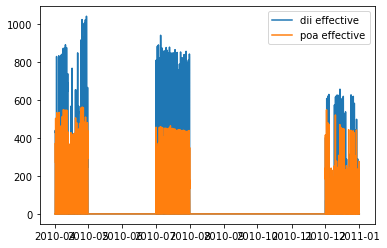

In [9]:
plt.plot(dii_effective, label='dii effective')
plt.plot(poa_flatplate_static_effective, label='poa effective')
plt.legend()
plt.show()

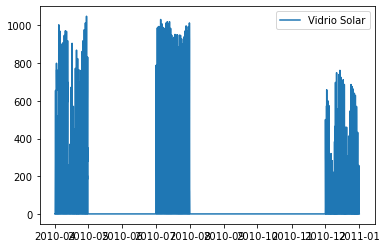

In [10]:
plt.plot(effectiveIrradiance, label='Vidrio Solar')
plt.legend()
plt.show()

In [11]:
data0

,temp_air,RH,ghi,dni,dhi,IR(h),wind_speed,WD10m,SP
time(UTC),,,,,,,,,
2010-04-01 00:00:00+00:00,9.59,65.54,0.0,0.0,0.0,280.43,1.84,278.0,94742.0
2010-04-01 01:00:00+00:00,8.50,71.11,0.0,0.0,0.0,281.29,1.91,281.0,94727.0
2010-04-01 02:00:00+00:00,7.42,76.68,0.0,0.0,0.0,282.16,1.97,284.0,94711.0
2010-04-01 03:00:00+00:00,6.33,82.25,0.0,0.0,0.0,283.02,2.04,285.0,94733.0
2010-04-01 04:00:00+00:00,5.25,87.82,0.0,0.0,0.0,283.89,2.10,286.0,94754.0
...,...,...,...,...,...,...,...,...,...
2010-12-31 19:00:00+00:00,6.11,99.50,0.0,0.0,0.0,319.88,1.43,132.0,94857.0
2010-12-31 20:00:00+00:00,6.03,99.43,0.0,0.0,0.0,318.29,1.36,127.0,94897.0
2010-12-31 21:00:00+00:00,5.95,99.37,0.0,0.0,0.0,316.70,1.29,127.0,94910.0
